# Detailed Balanced Chemical Reaction Networks are Generalized Boltzmann Machines

### William Poole (1), Tom Ouldridge (2), Manoj Gopalkrishnan (3), and Erik Winfree (1)
(1) Caltech
(2) Imperial College London
(3) IIT Bombay

### _Online Workshop on nucleaic acids, synthetic biology and artificail life: Engineering adn controlling out-of-equilibrium molecular systems_ 29-31 March 2021, Imperial College London.

_Please Use the Arrows (or Arrow Keys) to Navigate. __Down:__ More Details. __Right/Left:__ Prev/Next Section._

## Abstract ##

Stochastic Chemical Reaction Networks (CRNs) represent a biophysically realistic and expressivemodeling framework for biological systems. Detailed Balanced CRNs (dbCRNs) are a subclass of CRNs which admit an equilibrium distribution. This poster builds off our previou swork on [Chemical Boltzmann Machines (Poole et al. DNA 2017)](https://arxiv.org/abs/1707.06221) where we have shown that dbCRNs can exactly implement a stochastic neural network model called a Boltzmann Machine. This relationship illustrates that stochasticity can be advantageous because it allows a CRN to compactly represent complex distributions. We have shown that these CRNs are capable of inference, defined ascomputing conditional distributions, by “clamping” a subset of their species to a particular value. Finally, we have shown that the equilibrium distributions of dbCRNs can be learned by an externalin silico non-CRN algorithm that tunes the energies of individual molecular species. 

In new work,we have shown that the above results regarding inference and learning apply to any dbCRN, not just the Chemical Boltzmann Machine constructions. In this interactive poster, we examine physical processes that can tune species’ energies and are potentially implementable in a cell-like environment. The first uses a special kind of detailed balanced chemostat to control carefully designed chemical potentials that maintain detailed balance. The second uses a simple feedback circuit implementedas a non-detailed balanced CRN. These constructions provide equilibrium and non-equilibrium physical implementations that control the inference and learning process in dbCRNs. We then analyze these processes thermodynamically to provide lower bounds on the costs of inference andlearning. These results illustrate possible mechanisms whereby a biochemical system in a smallvolume, such as a cell, can represent and adapt to its environment.

# Boltzmann Machine Background
Boltzmann Machines (BMs) are an inspiration for this work. Briefly, they are a class of energy based machine learning models. BMs link machine learning and physics and can be defined equivalently in terms of graphical models, generalized Ising models, or stochastic Hopfield networks. In terms of this work, BMs provide two important sources of inspiratio:

### 1) BMs naturally perform inference (computing conditional distributions) when some of their nodes are held constant.

### 2) BMs make use of marginalization over hidden nodes in order to produce more complex distributions.

# Chemical Reaction Network Background:

Chemical Reaction Networks (CRNs) are a set of species $S$ and reactions $R$ of the form $\sum_i I_i S_i \to \sum_i O_i S_i$.

In this work, we consider stochastic chemical reaction networks which model Species' counts on the integer lattice as a Markov jump process as opposed to modeling the concentrations of molecular species. This is appropriate when considering small volumes with relatively few molecules, where stochasticity is known to be important.

We further are primarily interested in subclass of CRNs called detailed balanced(db) CRNs. There are many important theorems related to dbCRNs. In particular, they are amiable to thermodynamic and statistical mechanical analysis because they admit an equilibrium distribution.

# CRN Terminology:
* The __Reachability Class__ of a CRN are the set of states $\Omega(x_0)$ reachable via any series of reactions from an initial condition $x_0$


* The __Stoichiometric Compatability Class__ of a CRN is the kernel of the Stoichiometric Matrix $\mathbb{S} = O - I$, where $O^r_i$ and $I^r_i$ are the outputs and inputs of species $i$ in reaction $r$, respectively.


* A CRN is detailed  __Detailed Balanced__ if:
  * that every Species $S_i$ has an associated energy $E_i$.
  * all reactions are reversible $\sum_i I^r_i S_i \to \sum_i O^r_i S_i \implies \sum_i O^{r'}_i S_i \to \sum_i I^{r'}_i S_i$
  * reaction rates rates are set by the detailed balanced condition $\frac{k_f}{k_r} = e^{\Delta E_r}$ where $\Delta E_r = \sum_i I^r_i a_i E_i - O^r_i b_i E_i$

In [1]:
#*********************************************************
#************* HELPER FUNCTIONS DEFINED HERE *************
#********** RUN THIS CELL BUT DO NOT CHANGE IT! **********
#*********************************************************

%matplotlib inline
from bioscrape.types import Model
from bioscrape.simulator import py_simulate_model
import numpy as np
import pylab as plt
from scipy.sparse import csc_matrix
import matplotlib
from time import process_time

max_time = 10000 #Shorten this for faster, but less accurate, simulations

def db_rxns(inputs, outputs, EnergyDict):
    dE = sum([EnergyDict[o] for o in outputs])-sum([EnergyDict[i] for i in inputs])
    rxn1 = [inputs, outputs, "massaction", {"k":np.exp(-dE/2)}]
    rxn2 = [outputs, inputs, "massaction", {"k":np.exp(dE/2)}]
    return [rxn1, rxn2]

def chemostat_reactions(inputs, outputs, kf, kr):
    rxn1 = [inputs, outputs, "massaction", {"k":kf}]
    rxn2 = [outputs, inputs, "massaction", {"k":kr}]
    
    return [rxn1, rxn2]

def create_product_poisson_crn(E1 = -2, E2 = -2, E3 = -3, n = 0):
    E = {"X1":E1, "X2":E2, "X3":E3}
    species = ["X1", "X2", "X3"]
    reactions = db_rxns([], ["X1"], E)+db_rxns([], ["X2"], E) + db_rxns([], ["X3"], E)
    CRN = Model(species = species, reactions = reactions, initial_condition_dict = {"X1":n, "X2":0, "X3":0})
    return CRN

def create_restricted_CRN(E1 = -2, E2 = -2, E3 = 0, n = 30):
    E = {"X1":E1, "X2":E2, "X3":E3}
    species = ["X1", "X2", "X3"]
    reactions = db_rxns(["X1"], ["X2"], E)+db_rxns(["X2"], ["X3"], E)
    CRN = Model(species = species, reactions = reactions, initial_condition_dict = {"X1":n,"X2":0, "X3":0})
    return CRN

def create_happy_sad_CRN(E_C_s = 0, E_C_h = 0, E1 = 0, E2 = 0, n = 1):
    #Happy Face Array
    A_happy = np.zeros((10, 10)); A_happy[7, 3] = .5; A_happy[6, 3] = 1; A_happy[7, 6] = .5; A_happy[6, 6] = 1; A_happy[3, 2] = .5; A_happy[3, 7] = .5; A_happy[2, 3] = 1; A_happy[2, 6] = 1; A_happy[2, 4] = 1; A_happy[2, 5] = 1
    #Sad Face Array
    A_sad = np.zeros((10, 10)); A_sad[7, 3] = 1; A_sad[6, 3] = .5; A_sad[7, 6] = 1; A_sad[6, 6] = .5; A_sad[3, 2] = .5; A_sad[3, 7] = .5; A_sad[4, 3] = 1; A_sad[4, 6] = 1; A_sad[4, 4] = 1; A_sad[4, 5] = 1

    
    species = ["X1", "X2", "C_h", "C_s"]
    reactions = []
    E = {"X1":E1, "X2":E2, "C_h": E_C_h, "C_s":E_C_s}

    species_h = []
    species_s = []
    for i in range(10):
        for j in range(10):

            if A_sad[i, j] != 0:
                #Add sad pixel species
                s = "P_s_"+str(i)+"_"+str(j)
                species_s += [(s, i, j)]
                E[s] = -np.log(A_sad[i, j])-np.log(np.math.factorial(i))-np.log(np.math.factorial(j))

                #Add sad pixel reactions
                if len(species_s)>1:
                    s_prev, i_prev, j_prev = species_s[-2]
                    delta_i = i_prev - i
                    delta_j = j_prev - j
                    inputs = ["C_s", s_prev]
                    outputs = ["C_s", s]

                    if delta_i > 0:
                        inputs += delta_i * ["X2"]
                    elif delta_i < 0:
                        outputs += -delta_i *["X2"]

                    if delta_j > 0:
                        inputs += delta_j * ["X1"]
                    elif delta_j < 0:
                        outputs += -delta_j *["X1"]

                    reactions += db_rxns(inputs, outputs, E)


            if A_happy[i, j] != 0:
                #Add happy pixel species
                s = "P_h_"+str(i)+"_"+str(j)
                species_h += [(s, i, j)]
                E[s] = -np.log(A_happy[i, j])-np.log(np.math.factorial(i))-np.log(np.math.factorial(j))

                #Add happy pixel reactions
                if len(species_h)>1:
                    s_prev, i_prev, j_prev = species_h[-2]
                    delta_i = i_prev - i
                    delta_j = j_prev - j
                    inputs = ["C_h", s_prev]
                    outputs = ["C_h", s]

                    if delta_i > 0:
                        inputs += delta_i * ["X2"]
                    elif delta_i < 0:
                        outputs += -delta_i *["X2"]

                    if delta_j > 0:
                        inputs += delta_j * ["X1"]
                    elif delta_j < 0:
                        outputs += -delta_j *["X1"]

                    reactions += db_rxns(inputs, outputs, E)

    #Create a reaction switching happy to sad
    s_h, i_h, j_h = species_h[0]
    s_s, i_s, j_s = species_s[0]
    inputs = ["C_s", s_s]
    outputs = ["C_h", s_h]

    delta_i = i_s - i_h
    delta_j = j_s - j_h

    if delta_i > 0:
        inputs += delta_i * ["X2"]
    elif delta_i < 0:
        outputs += -delta_i *["X2"]

    if delta_j > 0:
        inputs += delta_j * ["X1"]
    elif delta_j < 0:
        outputs += -delta_j *["X1"]

    reactions += db_rxns(inputs, outputs, E)
    species += [i[0] for i in species_h] + [i[0] for i in species_s]
    CRN = Model(
        species = species,
        reactions = reactions, 
        initial_condition_dict = {"X1":j_h, "X2":i_h, "C_h":n, "C_s":0, s_h:n, s_s:0})
    
    return CRN

def bar_marginal(x, y, reverse = False, **keywords):
    new_x = [0]
    new_y = [0]
    for i in range(len(x)-1):
        new_x += [x[i], x[i+1]]
        new_y += [y[i], y[i]]
    new_x += [x[-1]]
    new_y += [0]
    if reverse:
        plt.plot(new_y, new_x, **keywords)
    else:
        plt.plot(new_x, new_y, **keywords)


# Detailed Balanced CRNs Can Generate Complex Distributions
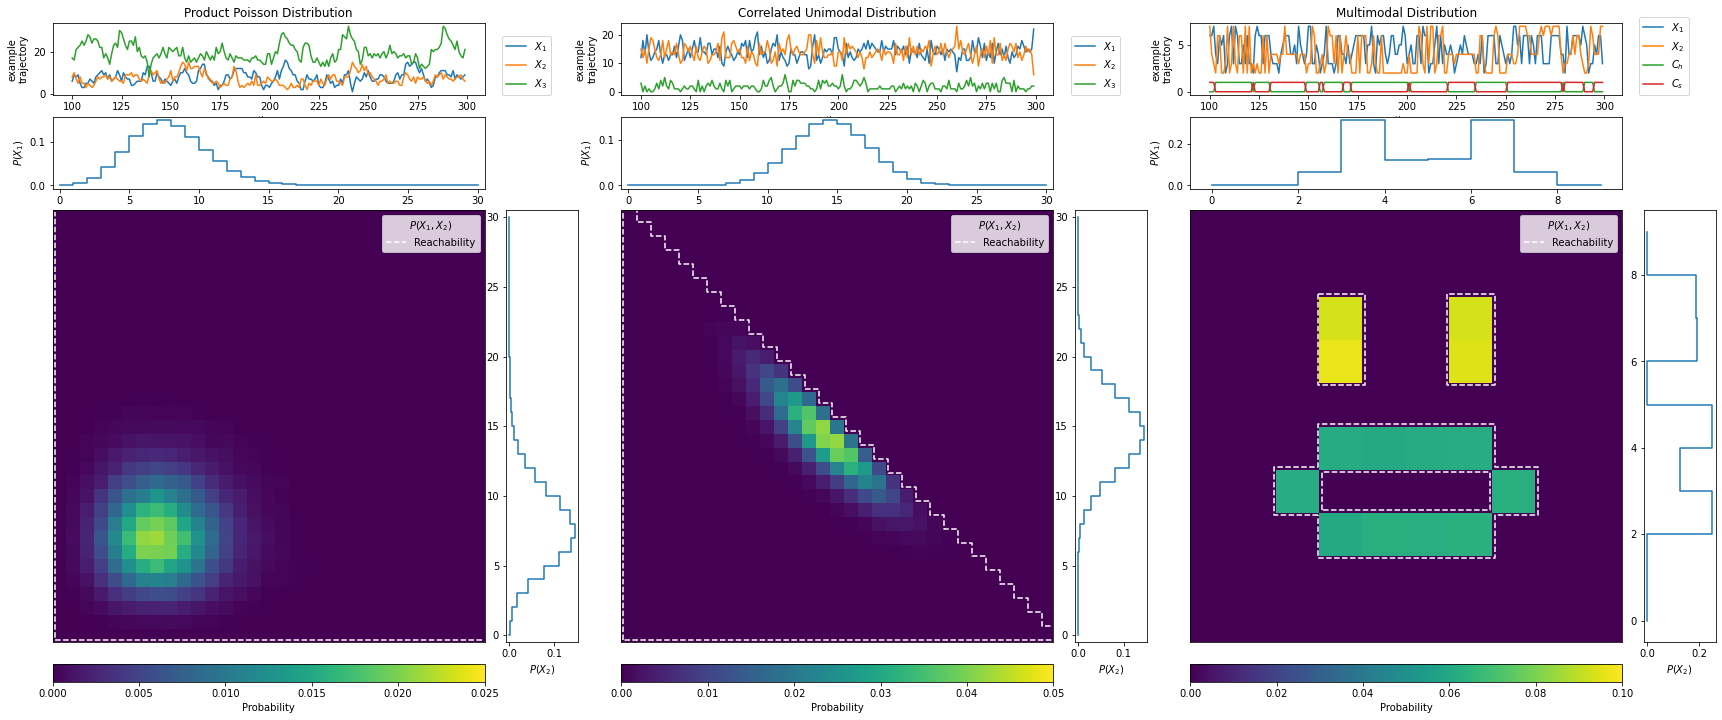

dbCRNs can produce 3 classes of distribution: (Left) Production Poisson Distributions cover the entire integer lattice. (Middle) Unimodal Correlated Distributions are created restricting the stoichiometric compatability class of the CRN. (Right) Complex Multimodal Distributions are created by carefully controlling the reachability class. 

# Example 1: Product Poisson Distribution

This product Poisson distribution is generated by the CRN:

## $\emptyset \leftrightharpoons X_1 \quad \emptyset \leftrightharpoons X_2 \quad \emptyset \leftrightharpoons X_3$

It has the cannonical poisson form:

## $\pi(x) = \prod_i \frac{1}{Z_i} e^{-E_i x_i - \log x_i !} \quad Z_i = \sum_{x' = 0}^\infty e^{-E_i x' - \log x' !} $

Notice that this distribution is in product form meaning all species are independent at equilibrium.

_Changing the Energies of each Species will only change the mean of that Species. Changing the initial condition will not change the distribution because the entire integer lattice is reachable._

Simulating Complete.


Text(0.5, 0, 'X2')

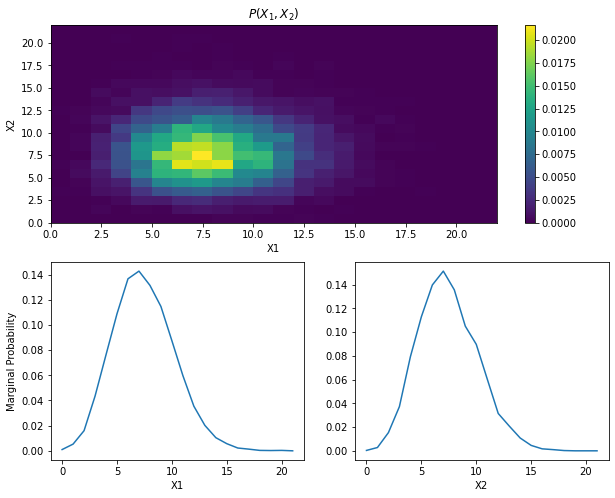

In [2]:
#*********************************************************
#************* Try Changing These Variables! *************
#*********************************************************

#Species' Energies
E1 = -2
E2 = -2
E3 = -3

#initial condition (for all Species)
n = 0


#*********************************************************
#************* Simulation and Plotting Below *************
#*********************************************************

CRN1 = create_product_poisson_crn(E1 = E1, E2 = E2, E3 = E3, n = n)

timepoints = np.arange(0, max_time, 1.)
results1 = py_simulate_model(timepoints, CRN1, stochastic = True, return_dataframe = False); print("Simulating Complete.")
df1 = results1.py_get_dataframe(Model = CRN1)
burn_in = max_time/10.
max_counts1 = int(max(max(df1["X1"]), max(df1["X2"]))+1)
E1_dist_X1_X2 = results1.py_empirical_distribution(species = ["X1", "X2"], start_time = burn_in, Model = CRN1, max_counts = [max_counts1, max_counts1])

E1_marg_X1 = results1.py_empirical_distribution(species = ["X1"], start_time = burn_in, Model = CRN1, max_counts = [max_counts1])
E1_marg_X2 = results1.py_empirical_distribution(species = ["X2"], start_time = burn_in, Model = CRN1, max_counts = [max_counts1])

plt.figure(figsize = (10, 8))
plt.subplot(211)
cb = plt.pcolor(E1_dist_X1_X2)
plt.colorbar(cb)
plt.title("$P(X_1, X_2)$")

plt.xlabel("X1")
plt.ylabel("X2")
plt.subplot(223)
plt.plot(E1_marg_X1)
plt.xlabel("X1")
plt.ylabel("Marginal Probability")
plt.subplot(224)
plt.plot(E1_marg_X2)
plt.xlabel("X2")


# Example 2: Correlated Unimodal Distribution

This restricted product Poisson Distribution is generated from the CRN:

### $X_1 \leftrightharpoons X_2 \leftrightharpoons X_3$

Although the equilibrium distribution can also be written in cannonical "Poisson" form, the partition function is no longer factorizable but instead must be written as a function of the reachability class $\Omega(x(0))$ which in turn depend on the initial condition. In this case, the reachability class is the stoichiometric subspace. 

### $\pi(x) = \frac{1}{Z} \prod_i  e^{-E_i x_i - \log x_i !} \quad Z = \sum_{x' \in \Omega(x(0))} e^{\sum_i -E_i x'_i - \log x'_i !} $

Due to the particular reaction network chosen, species will be anti-correlated with eachother.

_Changing the Energies of each Species will not only change the mean of that Species, but it will also induce changes in the means and variances of the other Species. Changing the initial condition will change which subset of the integer lattice is reachable also changing the distribution. However, the general shape of this distribution: 3 anti-correlated variables, is robust to changes of the energies and initial condition._

Simulating Complete.


Text(0.5, 0, '$X_2$')

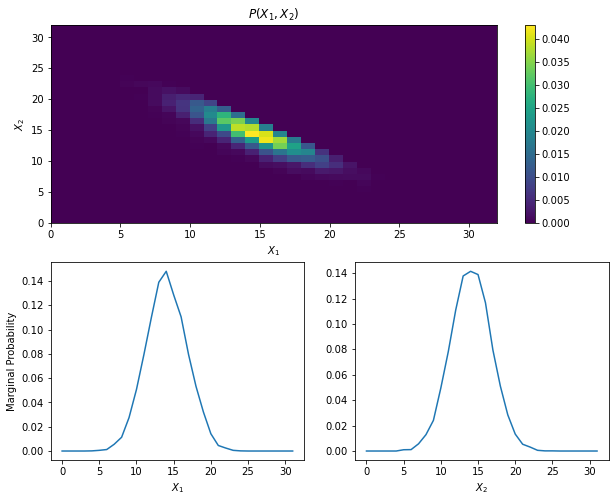

In [3]:
#*********************************************************
#************* Try Changing These Variables! *************
#*********************************************************

#Species Energies
E1 = -2
E2 = -2
E3 = 0

#Maximum Species' count
n = 30


#*********************************************************
#************* Simulation and Plotting Below *************
#*********************************************************

CRN2 = create_restricted_CRN(E1 = E1, E2 = E2, E3 = E3, n = n)

timepoints = np.arange(0, max_time, 1.)
results2 = py_simulate_model(timepoints, CRN2, stochastic = True, return_dataframe = False); print("Simulating Complete.")
df2 = results2.py_get_dataframe(Model = CRN2)
burn_in = max_time/10.
max_counts2 = int(max(max(df2["X1"]), max(df2["X2"]))+1)
E2_dist_X1_X2 = results2.py_empirical_distribution(species = ["X1", "X2"], start_time = burn_in, Model = CRN2, max_counts = [max_counts2, max_counts2])

E2_marg_X1 = results2.py_empirical_distribution(species = ["X1"], start_time = burn_in, Model = CRN2, max_counts = [max_counts2])
E2_marg_X2 = results2.py_empirical_distribution(species = ["X2"], start_time = burn_in, Model = CRN2, max_counts = [max_counts2])

plt.figure(figsize = (10, 8))
plt.subplot(211)
cb = plt.pcolor(E2_dist_X1_X2)
plt.colorbar(cb)
plt.title("$P(X_1, X_2)$")
plt.xlabel("$X_1$")
plt.ylabel("$X_2$")
plt.subplot(223)
plt.plot(E2_marg_X1)
plt.xlabel("$X_1$")
plt.ylabel("Marginal Probability")
plt.subplot(224)
plt.plot(E2_marg_X2)
plt.xlabel("$X_2$")

# Example 3: Multimodal Distribution

The previous example hinted that one Species in a dbCRN can strongly influence eachothers distributions. This example uses that premise to design a CRN with many hidden Species organized into a heirarchical network in order to generate a very specific distribution. This example is a modified from [Capalletti et al. 2019](https://arxiv.org/abs/1810.02854) where dbCRNs are constructed to produce arbitrary distributions with finite support. The CRN is divied into three sets of reactions

#### Happy Face Reactions: $C_h + P_h^{(i, j)} + i X_1 + j X_2 \leftrightharpoons C_h + P_h^{(l, m)} + l X_1 + m X_2$
#### Sad Face Reactions: $C_s + P_s^{(i, j)} + i X_1 + j X_2 \leftrightharpoons C_s + P_s^{(l, m)} + l X_1 + m X_2$
#### Transition Reactions: $C_h + P_h^{(i, j)} + i X_1 + j X_2 \leftrightharpoons C_s + P_s^{(l, m)} + l X_1 + m X_2$ 

Here, $C_h$ and $C_s$ are binary "control" Species which determine if a Happy or Sad face is formed. $P_s^{(i, j)}$ and $P_h^{(i, j)}$ denote Happy and Sad "pixel" species which represent the $i, j$ pixels seen in each face icon. The energies of the Pixels are tuned to counteract the changing entropies of the counts of $X_1$ and $X_2$ in order to produce a carefully tuned distribution. 

_The energies of $C_h$ and $C_s$ can be tuned to bias the distribution towards happy or sad. Changing $E_1$ and $E_2$ will further skew the distributions. Finally, this construction is reliant on thier only being a single Pixel Species and control Species present at any time. If this conservation law is broken, the reachability class rapidly expands and breaks the control over the equilibrium distribution._

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:136: UserWarning: The following species are uninitialized and their value has been defaulted to 0: P_h_2_4, P_h_2_5, P_h_2_6, P_h_3_2, P_h_3_7, P_h_6_3, P_h_6_6, P_h_7_3, P_h_7_6, P_s_3_7, P_s_4_3, P_s_4_4, P_s_4_5, P_s_4_6, P_s_6_3, P_s_6_6, P_s_7_3, P_s_7_6, 


Simulating Complete.


Text(0.5, 0, '$X_2$')

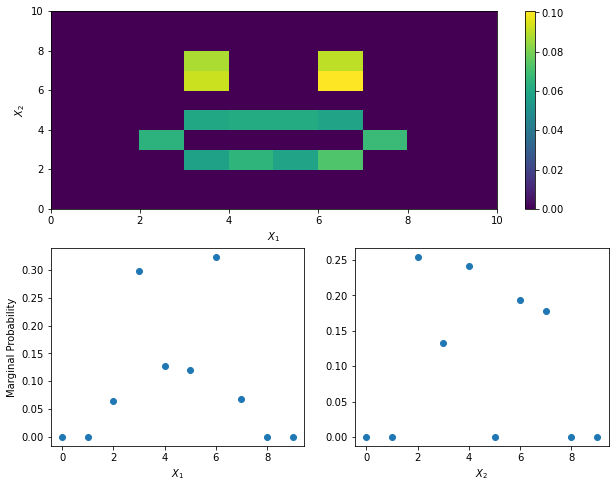

In [4]:
#*********************************************************
#************* Try Changing These Variables! *************
#*********************************************************

#Happy and Sad Energies
E_C_s = 0
E_C_h = 0

#Energies of X1 and X2
E1 = 0
E2 = 0

#The initial pixel and control Species count
n = 1



#*********************************************************
#************* Simulation and Plotting Below *************
#*********************************************************

CRN3 = create_happy_sad_CRN(E_C_s = E_C_s, E_C_h = E_C_s, E1 = E1, E2 = E2, n = n)
timepoints = np.arange(0, max_time, 1.)

results3 = py_simulate_model(timepoints, CRN3, stochastic = True, return_dataframe = False); print("Simulating Complete.")
df3 = results3.py_get_dataframe(Model = CRN3)
burn_in = max_time/10.
max_counts3 = int(max(max(df3["X1"]), max(df3["X2"]))+2)
E3_dist_X1_X2 = results3.py_empirical_distribution(species = ["X1", "X2"], start_time = burn_in, Model = CRN3, max_counts = [max_counts3, max_counts3])
E3_marg_X1 = results3.py_empirical_distribution(species = ["X1"], start_time = burn_in, Model = CRN3, max_counts = [max_counts3])
E3_marg_X2 = results3.py_empirical_distribution(species = ["X2"], start_time = burn_in, Model = CRN3, max_counts = [max_counts3])

plt.figure(figsize = (10, 8))
plt.subplot(211)
cb = plt.pcolor(E3_dist_X1_X2.T)
plt.colorbar(cb)
plt.xlabel("$X_1$")
plt.ylabel("$X_2$")
plt.subplot(223)
plt.plot(range(len(E3_marg_X1)), E3_marg_X1, 'o')
plt.xlabel("$X_1$")
plt.ylabel("Marginal Probability")
plt.subplot(224)
plt.plot(range(len(E3_marg_X2)), E3_marg_X2, 'o')
plt.xlabel("$X_2$")

# Detailed Balanced CRNs Can Perform Inference By "Clamping" Species to a Particular Value

We have demonstrated that changing the Energies' of a dbCRNs Species pushes that Species towards a higher or lower value. This form of energy modulation is also a form of inference which we all __clamping__. For example, by decreasing the energy of a Species we are making it more favorable and increasing its mean - effectively "holding" that Species at a higher value. We have proven that this is equivalent to computing a conditional distribution conditioned upon the "rare event" that a different mean was sampled from the equilibrium distribution.

### Informal Theorem: let $\pi(x)$ be the equilibrium distribution of a dbCRN with energy $E$. Then, let $\pi'(x)$ be the equilibrium distribution of a dbCRN with the same reactions but new energy $E' = E+\Delta$. These two CRNs are related via the [conditional limit theorem](http://staff.ustc.edu.cn/~cgong821/Wiley.Interscience.Elements.of.Information.Theory.Jul.2006.eBook-DDU.pdf): $\pi(x | \mathbb{E}[x]) = \mathbb{E}_{\pi'}[x]) = \pi'(x)$

_What this means, practically, is that varying the energies of a dbCRN's Species is a form of inference and can be used to compute conditional distributions!_

## Example 1: Clamping a $X_3$ in A Product Poisson Distribution Varies the Mean of $X_3$ But Does not Vary $X_1$ or $X_2$.

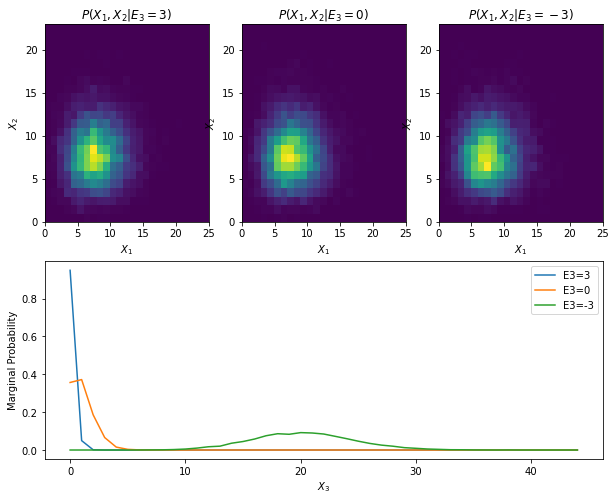

Simulating Complete.
Simulating Complete.
Simulating Complete.


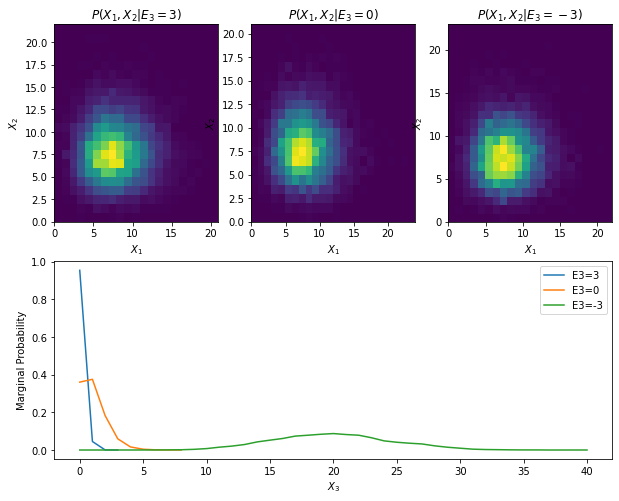

In [5]:
#*********************************************************
#************* Try Changing These Variables! *************
#*********************************************************

#vary the range of values X_3 is clamped to
E3_max = 3
E3_min = -3


#*********************************************************
#************* Simulation and Plotting Below *************
#*********************************************************
E3_list = [E3_max, 0, E3_min]
plt.figure(figsize = (10, 8))
axb = plt.subplot(212)
for i, E3 in enumerate(E3_list):
    CRN = create_product_poisson_crn(E3 = E3)
    
    timepoints = np.arange(0, max_time, 1.)
    results = py_simulate_model(timepoints, CRN, stochastic = True, return_dataframe = False); print("Simulating Complete.")
    df = results.py_get_dataframe(Model = CRN)
    max_countsX1 = int(max(df["X1"])+1)
    max_countsX2 = int(max(df["X2"])+1)
    max_countsX3 = int(max(df["X3"])+1)
    burn_in = max_time/10.
    dist_X1_X2 = results.py_empirical_distribution(species = ["X1", "X2"], start_time = burn_in, Model = CRN, max_counts = [max_countsX1, max_countsX2])
    marg_X3 = results.py_empirical_distribution(species = ["X3"], start_time = burn_in, Model = CRN, max_counts = [max_countsX3])

    plt.subplot(len(E3_list)*10+200+i+1)
    plt.pcolormesh(dist_X1_X2)
    plt.title(f"$P(X_1, X_2 | E_3 = {E3})$")
    plt.xlabel("$X_1$")
    plt.ylabel("$X_2$")
    
    plt.sca(axb)
    plt.plot(marg_X3, label = f"E3={E3}")

plt.xlabel("$X_3$")
plt.ylabel("Marginal Probability")
plt.legend()

## Example 2: Clamping a $X_3$ in A Correlated Unimodal Distributions Varies the Mean of $X_3$ which in turn varies the means and variances of $X_1$ and $X_2$.

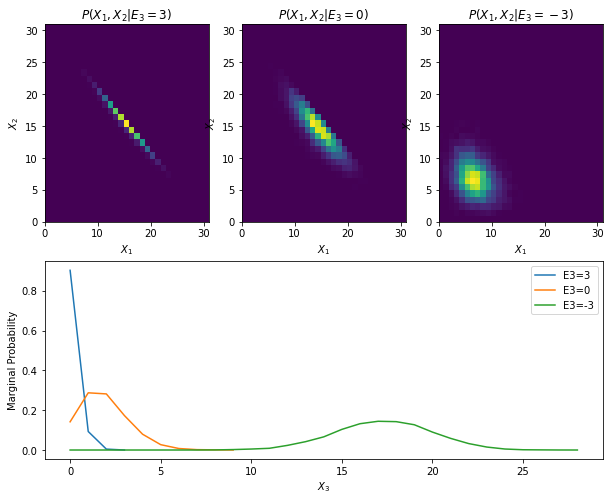

Simulating Complete.
Simulating Complete.
Simulating Complete.


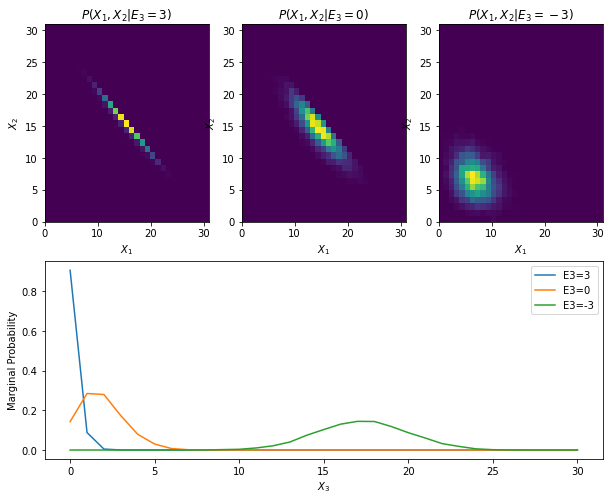

In [6]:
#*********************************************************
#************* Try Changing These Variables! *************
#*********************************************************

#vary the range of values X_3 is clamped to
E3_max = 3
E3_min = -3
n = 30

#*********************************************************
#************* Simulation and Plotting Below *************
#*********************************************************
E_list = [E3_max, 0, E3_min]
plt.figure(figsize = (10, 8))
axb = plt.subplot(212)
max_counts2 = n
for i, E3 in enumerate(E_list):
    CRN = create_restricted_CRN(E3 = E3, n = n)
    
    timepoints = np.arange(0, max_time, 1.)
    burn_in = max_time/10.
    
    results = py_simulate_model(timepoints, CRN, stochastic = True, return_dataframe = False); print("Simulating Complete.")
    df2 = results.py_get_dataframe(Model = CRN)
    
    dist_X1_X2 = results.py_empirical_distribution(species = ["X1", "X2"], start_time = burn_in, Model = CRN, max_counts = [max_counts2, max_counts2])    
    max_countsX3 = int(max(df2["X3"])+1)
    
    marg_X3 = results.py_empirical_distribution(species = ["X3"], start_time = burn_in, Model = CRN, max_counts = [max_counts2])
    
    plt.subplot(len(E3_list)*10+200+i+1)
    plt.pcolormesh(dist_X1_X2)
    plt.title(f"$P(X_1, X_2 | E_3 = {E3})$")
    plt.xlabel("$X_1$")
    plt.ylabel("$X_2$")
    
    plt.sca(axb)
    plt.plot(marg_X3, label = f"E3={E3}")
    
plt.xlabel("$X_3$")
plt.ylabel("Marginal Probability")
plt.legend()

## Example 3: Clamping a $C_h$ in A Multimodal Distributions Pushes the Binary Species $C_h$ and $C_s$ to be ON or OFF causing the distribution to switch from "Frowny" to "Smiley".

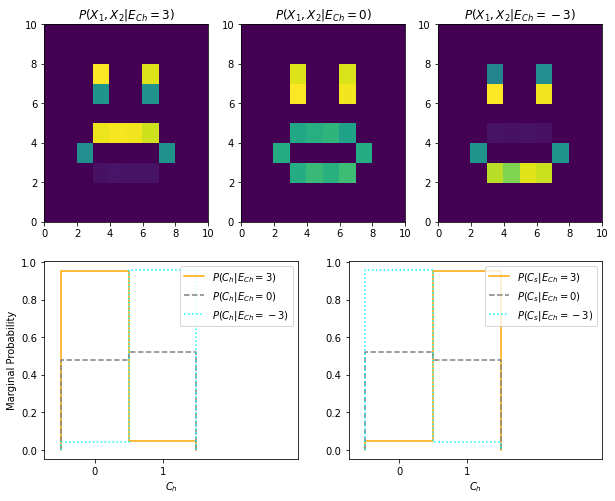

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:136: UserWarning: The following species are uninitialized and their value has been defaulted to 0: P_h_2_4, P_h_2_5, P_h_2_6, P_h_3_2, P_h_3_7, P_h_6_3, P_h_6_6, P_h_7_3, P_h_7_6, P_s_3_7, P_s_4_3, P_s_4_4, P_s_4_5, P_s_4_6, P_s_6_3, P_s_6_6, P_s_7_3, P_s_7_6, 


Simulating Complete.
Simulating Complete.
Simulating Complete.


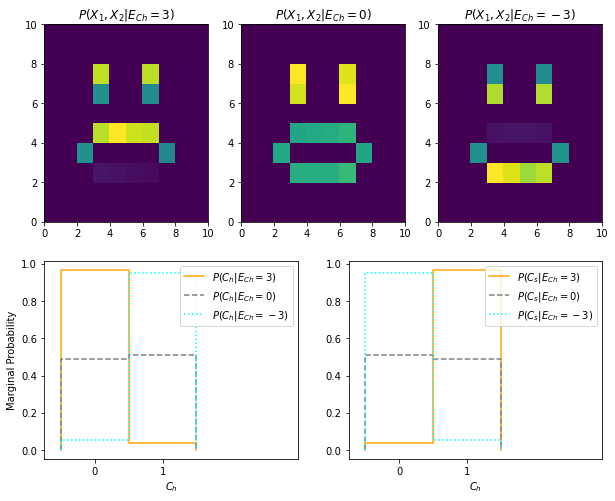

In [7]:
#*********************************************************
#************* Try Changing These Variables! *************
#*********************************************************

#vary the range of values C_h is clamped to
E3_max = 3
E3_min = -3


#*********************************************************
#************* Simulation and Plotting Below *************
#*********************************************************
plt.figure(figsize = (10, 8))
E_list = [E3_max, 0, E3_min]
color_list = ["orange", "gray", "cyan"]
ls_list = ["-", "--", ":"]
axb1 = plt.subplot(223)
axb2 = plt.subplot(224)
for i, E3 in enumerate(E_list):
    CRN = create_happy_sad_CRN(E_C_h = E3)
    
    timepoints = np.arange(0, max_time, 1.)
    results = py_simulate_model(timepoints, CRN, stochastic = True, return_dataframe = False); print("Simulating Complete.")
    burn_in = max_time/10.
    dist_X1_X2 = results.py_empirical_distribution(species = ["X1", "X2"], start_time = burn_in, Model = CRN, max_counts = [max_counts3, max_counts3])    
    marg_Ch = results.py_empirical_distribution(species = ["C_h"], start_time = burn_in, Model = CRN, max_counts = [2])
    marg_Cs = results.py_empirical_distribution(species = ["C_s"], start_time = burn_in, Model = CRN, max_counts = [2])
    
    plt.subplot(len(E3_list)*10+200+i+1)
    plt.title("$P(X_1, X_2 | E_{Ch} = "+str(E3)+")$")
    plt.pcolormesh(dist_X1_X2.T)
    
    plt.sca(axb1)
    bar_marginal(range(len(marg_Ch)), marg_Ch, color = color_list[i], label = "$P(C_h | E_{Ch} = "+str(E3)+")$", ls = ls_list[i])
    plt.sca(axb2)
    bar_marginal(range(len(marg_Cs)), marg_Cs, color = color_list[i], label = "$P(C_s | E_{Ch} = "+str(E3)+")$", ls = ls_list[i])

plt.sca(axb1)
plt.xlabel("$C_h$")
plt.ylabel("Marginal Probability")
plt.xticks([.5, 1.5], ["0", "1"])
plt.xlim(-.25, 3.5)
plt.legend()
plt.sca(axb2)
plt.xlabel("$C_h$")
plt.xticks([.5, 1.5], ["0", "1"])
plt.xlim(-.25, 3.5)
plt.legend()

## Clamping with Potential Chemostats

What does it mean to change the Energy of a Species? Evolutionarily, changes in sequences (nucleic, peptide etc.) could modulate binding energies, providing a connection between mathematical inference and evolution.

There are also more immediate ways to control the Species' energies. One implementation comes from coupling each Species $X_i$ to an external chemical potential $P_i$ such that whenever $X_i$ is changed in any reaction, $P_i$ is changed with it.

#### Informal Theorem: Let $\pi_P(x)$ be a dbCRN where species $X_i$ has energy $E_i$ and are coupled to a potential species $P_i$ with energy $E^P_i$. In the limit $p_i \to \infty$, the equilibrium distribution $\pi_P(x) = \pi'(x)$ where $\pi'(x)$ is a detailed balanced CRN without potential Species where $X_i$ has energy $E'_i = E_i + \Delta_i = E_i + E^P_i \log [P_i]$ where $[P_i]$ is the concentration of $P_i$ in a very large volume connected to the system. 

_In chemistry and physics, the term $E^P_i \log [P_i]$ is commonly known as the chemical potential $\mu$. This illustrates that inference via clamping via changing the energies of a detailed balanced CRN can be accomplished by modulating a chemical potential._

# Learning the Potential Chemostat Concentrations
Here, we show a (non detailed balanced) CRN which is capable of tuning the potential chemostat concentrations $[P_i]$ until $X_i$ have the desired mean. This is accomplished by augmenting any dbCRN with potential chemostats with two learning reactions per chemostat:

### $P_i + Q_i \to P_i \quad \quad P_i + X_i \to 2 P_i + X_i$

Here, $Q_i$ are external Species which encode the target means of $P_i$.

#### Informal Theorem: If these two reactions occur much more slowly than the equilibration of the $X_i$ species, then it can be shown that at steady state: $\frac{d P_i}{dt} = 0 \implies \mathbb{E}_\pi(x_i) = q_i$.

Convergence of a similar model has been proven for a CRN EM algorithm in [Virinchi et al. 2018](https://link.springer.com/chapter/10.1007/978-3-030-00030-1_12).

## Example 1: Learning the Mean of a Product Poisson
This CRN has four reactions:
$\emptyset \leftrightharpoons X + P \quad P + Q \to P \quad \quad P + X \to 2 P + X$
 
Although the above proof assumes $P$ is a deterministic Species, we simulate this CRN stochastically to avoid hybrid simulation.
 
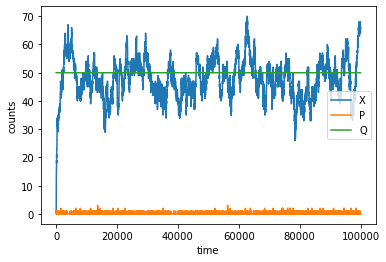
 
Notice that $X$ Fluctates around $Q$. 

Simulating Complete.


Text(0, 0.5, 'counts')

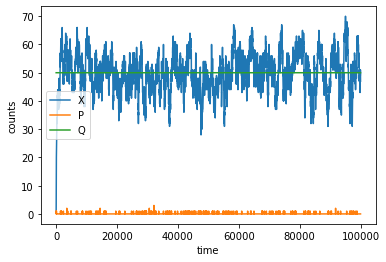

In [13]:
#*********************************************************
#************* Try Changing These Variables! *************
#*********************************************************

#Target Mean
Q = 50

#Energies
E_P = 0
E_X = 0

#learning rate
k_learning = .1


#*********************************************************
#************* Simulation and Plotting Below *************
#*********************************************************
E = {"X":E_X, "P":E_P, "Q":0}

species = ["X", "P", "Q"]
reactions = db_rxns([], ["X", "P"], E) #db Rection
reactions += chemostat_reactions(["X", "P"], ["X", "P", "P"], kf = k_learning, kr = 0) #learning reaction 1
reactions += chemostat_reactions(["Q", "P"], ["Q"], kf = k_learning, kr = 0) #learning reaction 2
x0 = {"X":1, "Q":Q, "P":1}

CRN_LP = Model(species = species, reactions = reactions, initial_condition_dict = x0)
timepoints = np.arange(0, 100000., 10.)

results_LP = py_simulate_model(timepoints, CRN_LP, stochastic = True, return_dataframe = True); print("Simulating Complete.")
plt.plot(results_LP["time"], results_LP["X"], label = "X")
plt.plot(results_LP["time"], results_LP["P"], label = "P")
plt.plot(results_LP["time"], results_LP["Q"], label = "Q")
plt.legend()
plt.xlabel("time")
plt.ylabel("counts")

## An XOR Chemical Boltzmann Machine (CBM)

A Chemical Boltzmann Machine is a dbCRN which exactly implements a Boltzmann Machine:

### $X^0 + Y^0 \leftrightharpoons X^1 + Y^0 \quad \quad X^0 + Y^0 \leftrightharpoons X^0 + Y^1$
### $X^1 + Y^0 + W^0 \leftrightharpoons X^1 + Y^1 + W^1 \quad \quad X^0 + Y^1 + W^0 \leftrightharpoons X^1 + Y^1 + W^1$

And an initial condition such that $X^0 + X^1 = 1 \quad Y^0 + Y^1 = 1 \quad W^0 + W^1 = 1 \quad X^1 Y^1 = W^1$


## Learning An XOR Chemical Boltzmann Machine (CBM)

By connecting the XOR CRN to 6 Chemostats (one for each Species) and 12 learning Reactions, we get a non-detailed balanced CRN which dynamically adjusts the potential species until the distribtion $\pi(x | P) = Q$.

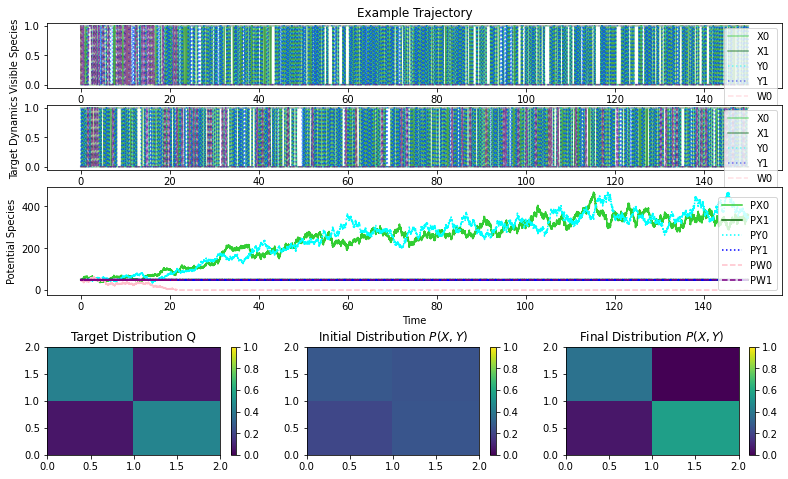



# Thermodynamics of Inference & Learning

Clamping with Potential Chemostats allows for a thermodynamic treatment of inference and learning. The idea is the imagine varying the volume $V_i$ of an ideal dilute solution of $P_i$ in order to adjust the concentrations $[P_i]$ which in turn vary Species' energies. This allows classical thermodynamics of ideal gasses to be applied to clamping via inference. This analysis is closely inspired by [Ouldridge et al. 2018](https://arxiv.org/abs/1812.09572).

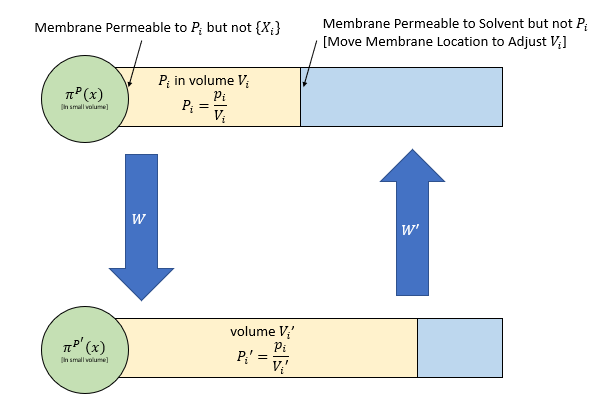

## Reversible Case

Consider a reversible (quasi-static) transition:

### $(V, \pi^P(x)) \implies (V', \pi^{P'}(x))$

### Informal Theorem: The CRN is always at equilibrium relative to the potential chemostats as the volume is changed (very slowly). The work needed for this process is just the amount needed to compress/expand pistons containing the Species $P_i$. Furthermore, no energy will be dissipated by this process assuming perfect pistons.

## Irreversible Case
Next consider an irreversible transition where the volume is varied instaneously (and in particular, faster than the CRN can equilibrate). Assuming ideal pistons, membranes, etc. The transitions now take the form:

### $(V, \pi^P(x)) \implies (V', \pi^{P}(x)) \implies (V', \pi^{P'}(x))$

### Informal Theorem: The CRN is not at equilibrium relative to the potential chemostats after the volume is changed (very quickly). The work needed for this process is just the amount needed to compress/expand pistons containing the Species $P_i$. However, in this case energy will be dissipated due to the equilibration of the CRN from $(V', \pi^P) \implies (V', \pi^{P'})$. This dissipation is equal to the Relative Entropy $D(\pi^P || \pi^{P'})$.